# A journey Through PRML

In [356]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from time import sleep
from requests_html import HTMLSession

In [611]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)

In [ ]:
api_token = os.environ["TOGGL-API-TOKEN"]
password = os.environ["TOGGL-PASSWORD"]
mail = "g.duran@me.com"

In [241]:
headers = {
    "Content-Type": "application/json"
}

In [250]:
url_me = "https://api.track.toggl.com/api/v8/me"
r = requests.get(url_me, headers=headers, auth=(mail, password))
data = r.json()["data"]
print(data["fullname"], data["created_at"])

Gerardo Durán 2015-04-28T02:55:50+00:00


## Get workspaces

In [251]:
url_workspace = "https://api.track.toggl.com/api/v8/workspaces"
r = requests.get(url_workspace, headers=headers, auth=(mail, password))
workspace_id = r.json()[0]["id"]
workspace_id

921814

## Get workspace projects

In [252]:
url_projects = f"https://api.track.toggl.com/api/v8/workspaces/{workspace_id}/projects"
r = requests.get(url_projects, headers=headers, auth=(mail, password))

ml_project, *_ = [project for project in r.json() if project["name"] == "Machine Learning"]
ml_project

{'id': 15174272,
 'guid': 'c38bdfe7-084c-41fa-bcac-91fbb6e8a672',
 'wid': 921814,
 'name': 'Machine Learning',
 'billable': False,
 'is_private': True,
 'active': True,
 'template': False,
 'at': '2020-06-09T02:16:07+00:00',
 'created_at': '2016-04-14T04:35:49+00:00',
 'color': '6',
 'auto_estimates': False,
 'actual_hours': 2695,
 'hex_color': '#06a893'}

## My Time Entries

In [182]:
time_ranges = ["2018-01-01", "2019-01-01", "2020-01-01", "2020-09-19"]
time_ranges = [(init, end) for init, end in zip(time_ranges[:-1], time_ranges[1:])]

In [187]:
def extract_report(start_date, end_date, project_id, api_token, page=1):
    url_details = "https://api.track.toggl.com/reports/api/v2/details"
    params = {
        "user_agent": mail
        "workspace_id": workspace_id,
        "since": start_date,
        "until": end_date,
        "page": page,
        "project_ids": project_id
    }
    r = requests.get(url_details, params=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

In [197]:
total_entries = []
for start_date, end_date in tqdm(time_ranges):
    info = extract_report(start_date, end_date, ml_project["id"], api_token).json()
    entries, per_page_entries = info["total_count"], info["per_page"]
    n_pages = entries // per_page_entries + 1
    total_entries.extend(info["data"])
    sleep(1)
    for page in tqdm(range(2, n_pages + 1), leave=False):
        info = extract_report(start_date, end_date, ml_project["id"], api_token, page=page).json()
        total_entries.extend(info["data"])
        sleep(1)

In [198]:
len(total_entries)

2374

# PRML

In [427]:
prml = pd.DataFrame(total_entries).set_index("start")
prml = prml[prml.description.str.contains("^[Bb]ishop")].sort_index()
prml.index = pd.to_datetime(prml.index, utc=True).tz_convert('America/Mexico_City')
prml = prml.sort_index()
prml.head()

,id,pid,tid,uid,description,end,updated,dur,user,use_stop,client,project,project_color,project_hex_color,task,billable,is_billable,cur,tags
start,,,,,,,,,,,,,,,,,,,
2018-07-10 17:20:59-05:00,920407819,15174272,None,1670359,Bishop Ch3,2018-07-10T17:36:24-05:00,2018-07-10T17:36:24-05:00,925000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-11 12:48:17-05:00,921304355,15174272,None,1670359,Bishop Ch3,2018-07-11T12:56:28-05:00,2018-07-11T12:56:28-05:00,491000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-13 13:09:52-05:00,923358919,15174272,None,1670359,Bishop Ch3,2018-07-13T14:52:18-05:00,2018-07-13T14:52:19-05:00,6146000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-13 20:20:59-05:00,923538451,15174272,None,1670359,Bishop Ch3,2018-07-13T21:30:07-05:00,2018-07-13T21:30:22-05:00,4148000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-14 06:36:54-05:00,923603030,15174272,None,1670359,Bishop Ch1,2018-07-14T06:40:13-05:00,2018-07-14T06:40:15-05:00,199000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]


In [542]:
prml["clocked_hours"] = prml["dur"] * 0.001 / 60 ** 2

## Temporal Analysis

In [543]:
# Date of the first time entry
prml.index.min().strftime("%Y-%m-%d")

'2018-07-10'

In [544]:
# Total time of tracked study
prml.index.max() - prml.index.min()

Timedelta('792 days 02:38:44')

In [546]:
prml["clocked_hours"].sum()

1542.726842222222

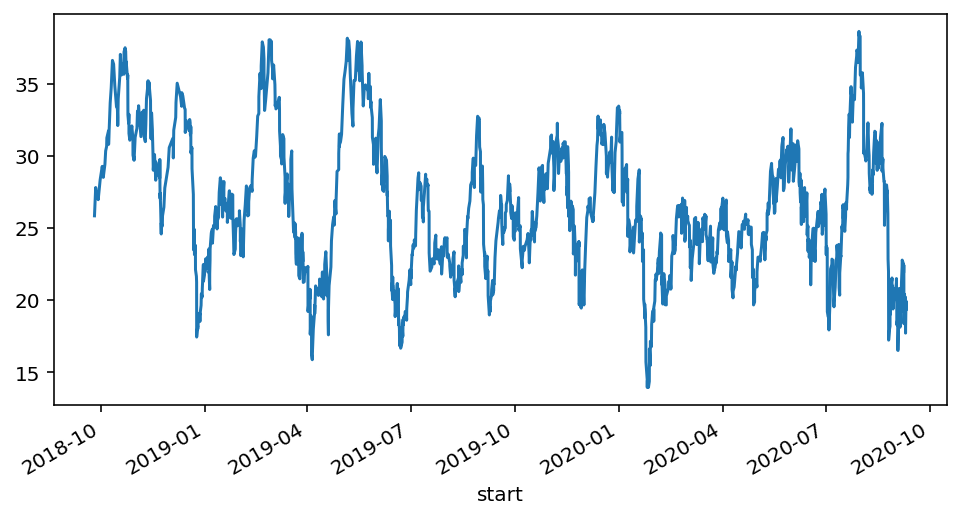

In [624]:
prml["clocked_hours"].rolling(30).sum().plot()

In [559]:
# Total number of days
prml["clocked_hours"].sum() / 24

64.28028509259259

In [560]:
start_values = prml.reset_index()[["start", "clocked_hours"]]
start_values["weekday"] = start_values["start"].apply(lambda v: v.weekday())
start_values["time"] = start_values["start"].apply(lambda v: v.hour + v.minute / 60)

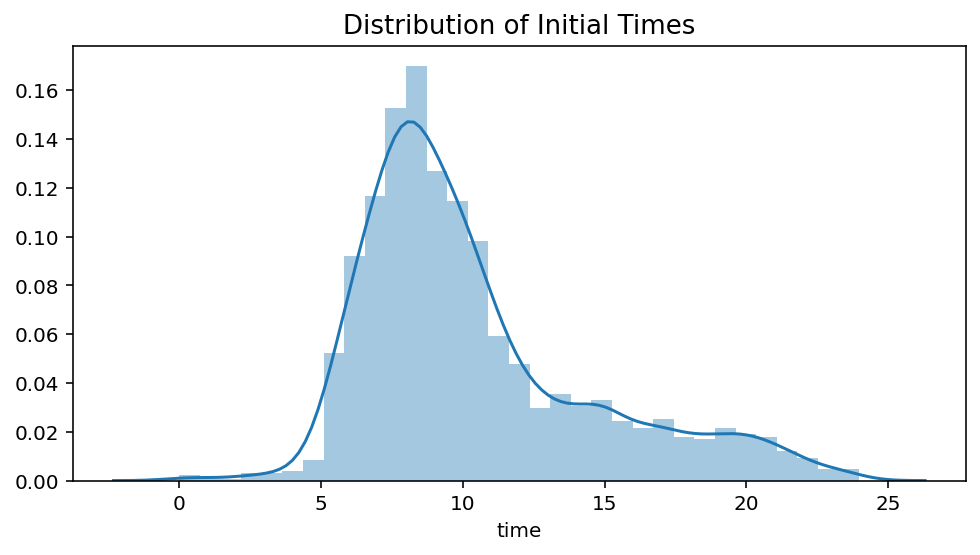

In [613]:
sns.distplot(start_values["time"])
plt.title("Distribution of Initial Times", fontsize=13);

In [590]:
start_values["time"].mean()

10.389118303571431

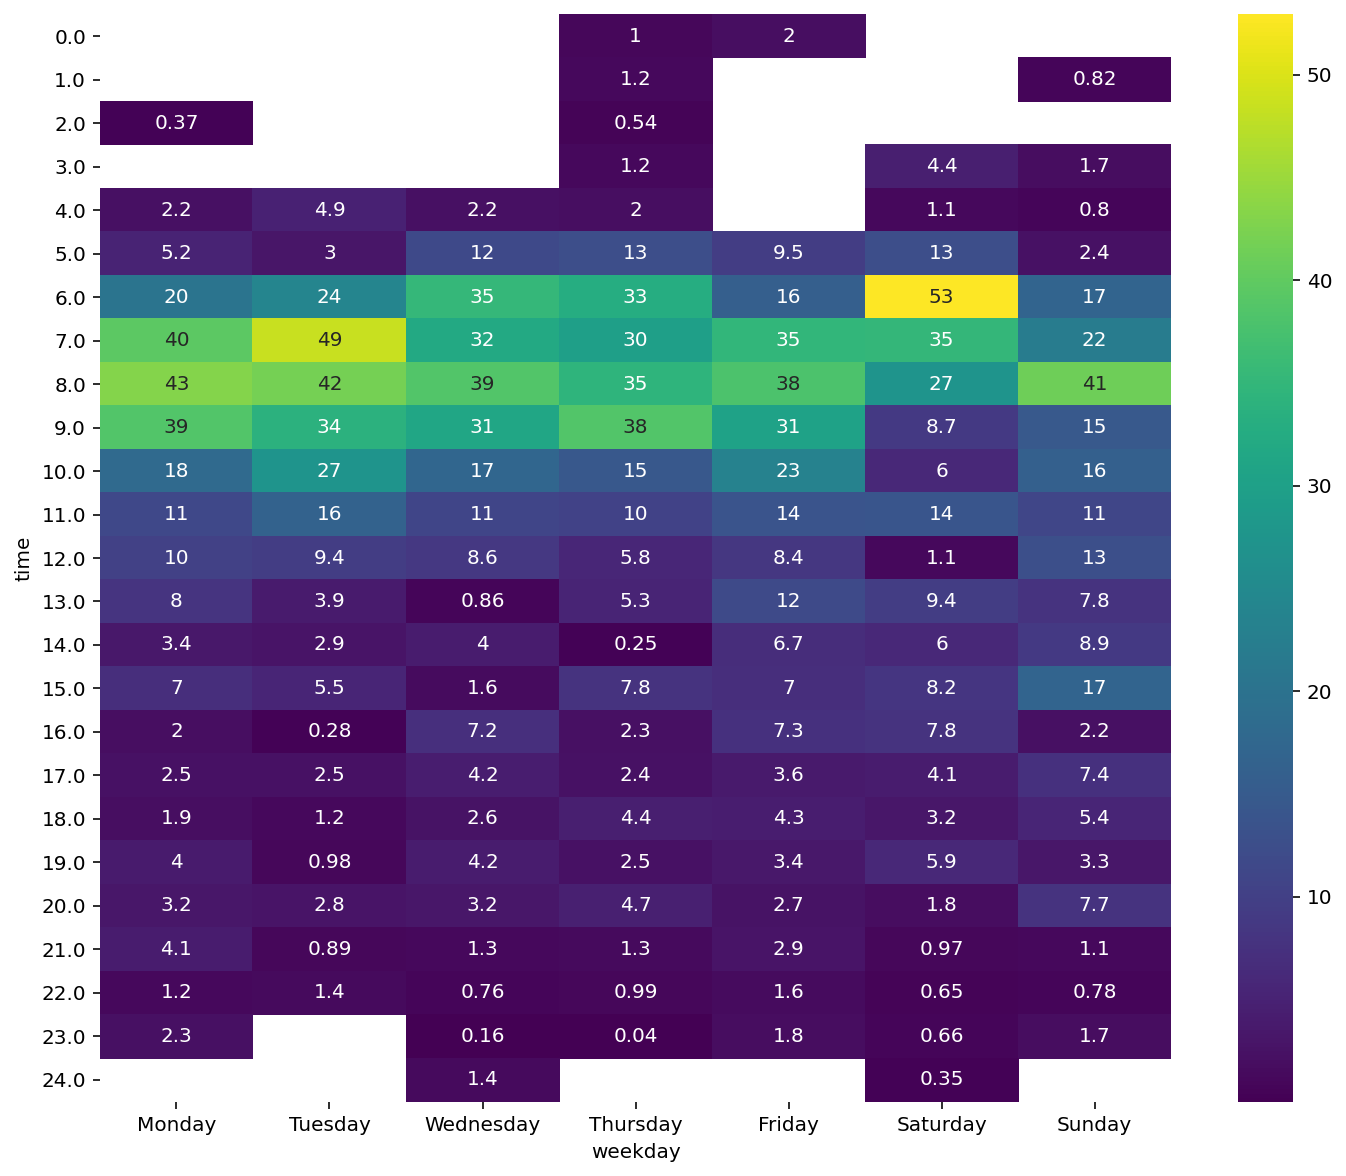

In [589]:
# Total total number of clocked hours groupped by starting time and weekday
time_distribution = (start_values.assign(time=start_values.time.round())
                                 .pivot_table(columns="weekday", index="time",
                                              values="clocked_hours", aggfunc="sum"))

fig, ax = plt.subplots(figsize=(12, 10))
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(time_distribution, annot=True, cmap="viridis", xticklabels=weekdays);

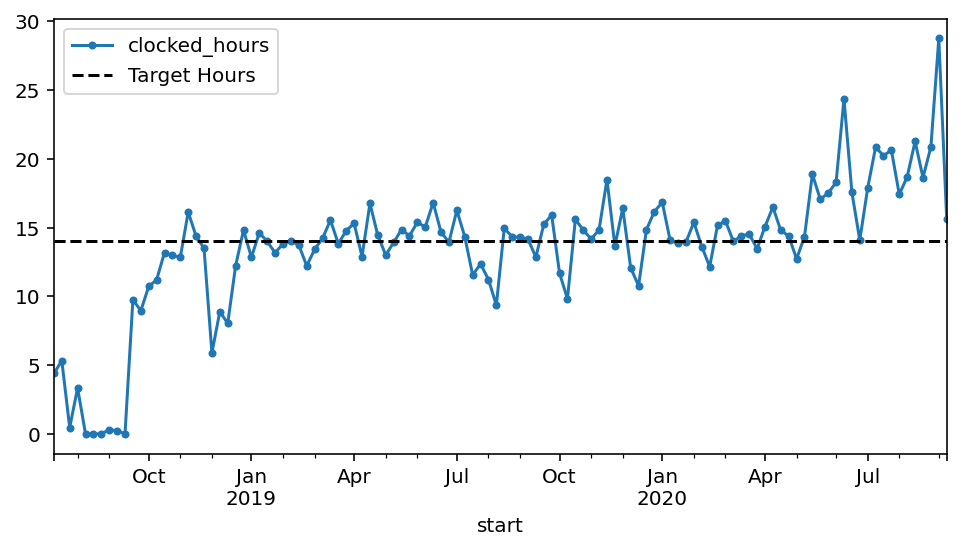

In [616]:
hours_per_week = prml.resample("W")["clocked_hours"].sum()
hours_per_week.plot(marker="o", markersize=3)
plt.axhline(y=14, c="black", linestyle="--", label="Target Hours")

plt.legend();

In [594]:
(hours_per_week >= 14).mean()

0.5526315789473685

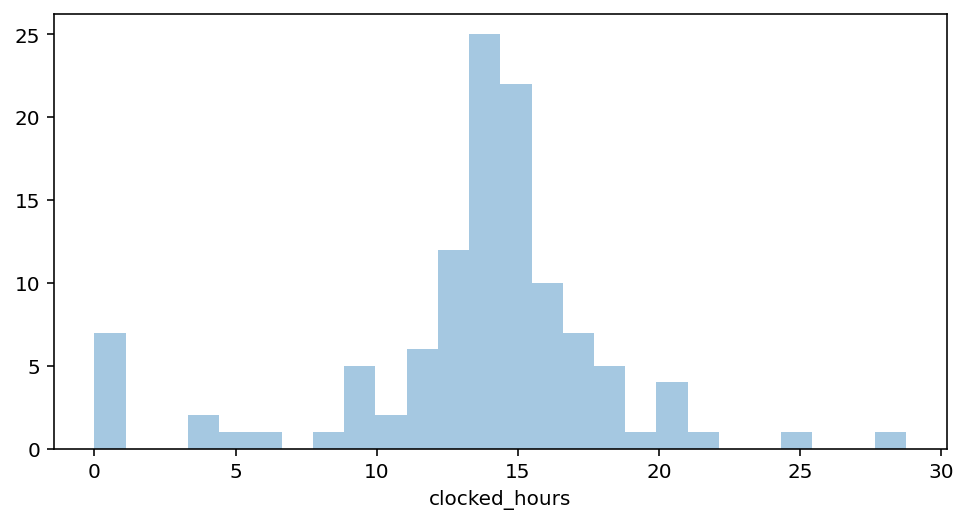

In [615]:
sns.distplot(hours_per_week, kde=False)

In [604]:
(hours_per_day == 0).mean()

0.10718789407313997

## Chapter Analysis

In [240]:
prml["description"].unique()

array(['Bishop Ch3', 'Bishop Ch1', 'Bishop Ch.1', 'Bishop Ch.1 notes',
       'Bishop Ch.2', 'Bishop Ch.3', 'Bishop Ch.4', 'Bishop Ch.5',
       'Bishop Ch.6', 'Bishop Ch.7', 'Bishop Ch.8', 'Bishop Ch.9',
       'Bishop Ch.10', 'Bishop Ch.11', 'Bishop Ch.12', 'Bishop Ch.13',
       'Bishop Ch.14'], dtype=object)

In [299]:
ms_chapter = (prml.assign(chapter=prml.description.str.extract("([0-9]+)").astype(int))
                  .groupby("chapter")["dur"]
                  .sum())
hour_chapter = ms_chapter * 0.001 / 60 ** 2
hour_chapter.name = "study-hours"

hour_chapter.mean() + np.array([-1, 1]) * hour_chapter.std()

array([ 48.37454781, 172.01500108])

In [301]:
url = "http://lear.inrialpes.fr/people/Jegou/bishopreadinggroup/"
with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [312]:
chapter_names = [v.text for v in r.html.find("h3")]
hour_chapter.index = chapter_names
hour_chapter

Chapter 1: Introduction                        128.755833
Chapter 2: Probability distributions           208.143611
Chapter 3: Linear Models for Regression        105.791389
Chapter 4: Linear Models for Classification    102.149167
Chapter 5: Neural Networks                     200.052120
Chapter 6: Kernel Methods                       61.676944
Chapter 7: Sparse Kernel Machines               79.763056
Chapter 8: Graphical Models                     96.968333
Chapter 9: Mixture Models and EM                79.607500
Chapter 10: Approximate Inference              226.593056
Chapter 11: Sampling Methods                    27.502500
Chapter 12: Continuous Latent Variables         91.390833
Chapter 13: Sequential Data                    104.260833
Chapter 14: Combining Models                    30.071667
Name: study-hours, dtype: float64

In [314]:
# Chapter with longest time of study
hour_chapter.idxmax()

'Chapter 10: Approximate Inference'

In [315]:
# Chapter with shortest time of study
hour_chapter.idxmin()

'Chapter 11: Sampling Methods'

## References
* [Detailed Report](https://github.com/toggl/toggl_api_docs/blob/master/reports/detailed.md)
* [Toggl Reports](https://github.com/toggl/toggl_api_docs/blob/master/reports.md)